<a href="https://colab.research.google.com/github/threewisemonkeys-as/dl_fun/blob/master/oneshot_learning/Siamese_Oneshot_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import random

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
 
import torchvision
import torchvision.transforms as T
from torchvision.datasets import Omniglot

import matplotlib

import matplotlib.pyplot as plt

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython.core.debugger import set_trace
    from IPython import display
plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
background = Omniglot('omniglot/', background=True, download=True)
evaluation = Omniglot('omniglot/', background=False, download=True)
print(len(background), len(evaluation))

0it [00:00, ?it/s]

9469952it [00:01, 5924950.00it/s]          


Extracting omniglot/omniglot-py/images_background.zip to omniglot/omniglot-py


0it [00:00, ?it/s]

6463488it [00:01, 4078621.37it/s]                              


Extracting omniglot/omniglot-py/images_evaluation.zip to omniglot/omniglot-py
19280 13180


Shape of Input: (105, 105)


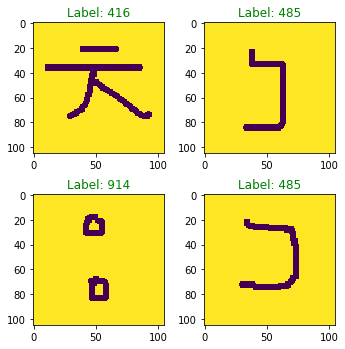

In [0]:

plt.figure(figsize=(5,5))
sample = background[random.randrange(len(background))]
print(f"Shape of Input: {sample[0].size}")

for i in range(4):
    sample = background[random.randrange(len(background))]
    ax = plt.subplot(2, 2, i + 1)
    plt.tight_layout()
    ax.set_title(f"Label: {sample[1]}", color='g')
    plt.imshow(sample[0])

plt.show()

In [0]:
def get_output_shape(input_shape, module, batch_size=1):
    dummy_input = Variable(torch.rand(batch_size, *input_shape, device=device))
    output_feat = module(dummy_input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size


In [0]:
class Net(nn.Module):

  def __init__(self, input_shape):
      super(Net, self).__init__()

      self.feature_extractor = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5), # 1x28x28 --> 32x24x24
              nn.ReLU(),
              nn.MaxPool2d(2, 2), # 32x24x24 --> 32x12x12
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 32x12x12 --> 64x12x12
              nn.ReLU(),
              nn.MaxPool2d(2, 2), # 64x12x12 --> 64x6x6
              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 64x6x6 --> 128x6x6
              nn.ReLU(),
              nn.MaxPool2d(2, 2), # 128x6x6 --> 128x3x3
              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3), # 128x3x3 --> 256x1x1
          )
      
      n_size = get_output_shape(input_shape, module=self.feature_extractor)
      
      self.dense = nn.Sequential(
              nn.Linear(n_size, 1024),
              nn.Linear(1024, 10),
          )

  def forward(self, x):
      features = self.feature_extractor(x)
      features = features.view(features.size(0), -1)
      predictions = self.dense(features)

      return predictions


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
classifier = Net((1, 28, 28))
classifier.load_state_dict(torch.load('/content/drive/My Drive/dl/mnist_classifier.pth'))
classifier.to(device)
classifier

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  )
  (dense): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [0]:
class Siamese(nn.Module):
    
    def __init__(self, input_shape):
        super(Siamese, self).__init__()
        
        self.input_shape = input_shape
        
    def forward(self, x, y):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        encoded_x = self.common_dense(x)
        
        y = self.feature_extractor(y)
        y = y.view(y.size(0), -1)
        encoded_y = self.common_dense(y)
        
        diff = self.abs_diff(encoded_x, encoded_y)
        
        prediction = self.final_dense(diff)

        return prediction

In [0]:
def get_batch(data, BATCH_SIZE):
    n = len(data)

    transform = T.Compose([
        T.Resize((28, 28)),
        T.ToTensor(),
    ])

    _, h, w = transform(data[0][0]).shape
    
    pairs = [torch.zeros((BATCH_SIZE, 1, h, w), device=device) for _ in range(2)]
    targets = torch.zeros((BATCH_SIZE, 1), device=device)
    
    for i in range(BATCH_SIZE):
        idx = random.randrange(n)
        dx = data[idx]
        ndx = dx[1]
        pairs[0][i, :, :, :] = transform(dx[0]).unsqueeze(0)

        if i < (BATCH_SIZE // 2):
            targets[i] = 1
            idy = random.randrange(20*ndx, 20*(ndx + 1))
        else:
            targets[i] = 0
            idy = random.randrange(n)
        
        pairs[1][i, :, :, :] = transform(data[idy][0]).unsqueeze(0)
    
    return pairs, targets
    

def get_oneshot_task(data, N):
    n = len(data)

    transform = T.Compose([
        T.Resize((28, 28)),
        T.ToTensor(),
    ])

    _, h, w = transform(data[0][0]).shape


        
    idx = random.randrange(n)
    sample = transform(data[idx][0]).unsqueeze(0).repeat(N, 1, 1, 1)
    ndx = data[idx][1]

    group = torch.zeros((N, 1, h, w), device=device)

    idy = random.randrange(20*ndx, 20*(ndx + 1))
    group[0, :, :, :] = transform(data[idy][0]).unsqueeze(0)

    for i in range(1, N - 1):
      idy = random.randrange(n)
      while 20*ndx <= idy and idy < 20*(ndx + 1):
        idy = random.randrange(n)
      group[i, :, :, :] = transform(data[idy][0]).unsqueeze(0)

    
    return sample.to(device), group

def test_n_way_accuracy(classifier, data, ITERATIONS, N=1, VERBOSE=False):
    classifier.eval()

    if VERBOSE:
      print("Starting testing proccess ... \n")

    record = []
    n = ITERATIONS
    
    for i_episode in range(ITERATIONS):
        
        sample, group = get_oneshot_task(data, N)
    
        scores = classifier(sample, group)

        record.append(torch.argmax(scores).item() == 0)
        
        if (i_episode+1) % (n/10) == 0 and VERBOSE:
            print(f"Episode {i_episode + 1} / {n} ({((i_episode + 1)*100) // n}%) | Running Accuracy = {(sum(record) / len(record)):.4f}")

    acc = (sum(record) / len(record))

    if VERBOSE:
      print(f"\nComplete! - {acc*100}% Accuracy\n")

    return acc

def train(classifier, data, criterion_type, optimizer_type, 
          ITERATIONS, BATCH_SIZE=1, LEARNING_RATE=0.001, VERBOSE=False):
    criterion = criterion_type().to(device)
    optimizer = optimizer_type(classifier.parameters(), lr=LEARNING_RATE)
    classifier.train()
    
    print("Starting training proccess ... \n")

    losses = []
    accuracies = []
    
    for i_episode in range(ITERATIONS):
        optimizer.zero_grad()
        
        pairs, targets = get_batch(data, BATCH_SIZE)
    
        prediction = classifier(*pairs)
        loss = criterion(prediction, targets)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()    
        
        #if (i_episode+1) % (n/100) == 0 :
        #  accuracies.append(test_n_way_accuracy(classifier, data, ITERATIONS=250, N=25))

        if (i_episode+1) % (ITERATIONS/10) == 0 and VERBOSE:
            print(f"Episode {i_episode + 1} / {ITERATIONS} ({((i_episode + 1)*100) // ITERATIONS}%) | Running Loss of last 5% ({ITERATIONS // 20}) = {(sum(losses[-(ITERATIONS//20):]) / len(losses[-(ITERATIONS//20):])):.4f}")

        
    print(f"\nComplete!\n")
    plt.plot(losses)
   # plt.plot(accuracies)

In [0]:
input_shape = (1, 28, 28)
s = Siamese(input_shape)
s.feature_extractor = classifier.feature_extractor
s.feature_extractor.requires_grad = False
n_size = get_output_shape(input_shape, s.feature_extractor)
s.common_dense = nn.Sequential(
    nn.Linear(n_size, 4096),
    nn.Sigmoid(),
)
s.abs_diff = lambda x, y: torch.abs(x - y)
s.final_dense = nn.Sequential(
    nn.Linear(4096, 1),
    nn.Sigmoid(),
)
s.to(device)

Siamese(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  )
  (common_dense): Sequential(
    (0): Linear(in_features=256, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (final_dense): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [0]:
pairs, targets = get_batch(background, 2)
preds = s(*pairs)
print(pairs[0].shape, pairs[1].shape)
print(preds, targets)
print(preds.shape, targets.shape)

torch.Size([2, 1, 28, 28]) torch.Size([2, 1, 28, 28])
tensor([[0.5186],
        [0.4965]], device='cuda:0', grad_fn=<SigmoidBackward>) tensor([[1.],
        [0.]], device='cuda:0')
torch.Size([2, 1]) torch.Size([2, 1])


Starting training proccess ... 

Episode 1000 / 10000 (10%) | Running Loss of last 5% (500) = 0.1038
Episode 2000 / 10000 (20%) | Running Loss of last 5% (500) = 0.1032
Episode 3000 / 10000 (30%) | Running Loss of last 5% (500) = 0.1023
Episode 4000 / 10000 (40%) | Running Loss of last 5% (500) = 0.1012
Episode 5000 / 10000 (50%) | Running Loss of last 5% (500) = 0.0974
Episode 6000 / 10000 (60%) | Running Loss of last 5% (500) = 0.0961
Episode 7000 / 10000 (70%) | Running Loss of last 5% (500) = 0.0947
Episode 8000 / 10000 (80%) | Running Loss of last 5% (500) = 0.0920
Episode 9000 / 10000 (90%) | Running Loss of last 5% (500) = 0.0909
Episode 10000 / 10000 (100%) | Running Loss of last 5% (500) = 0.0888

Complete!



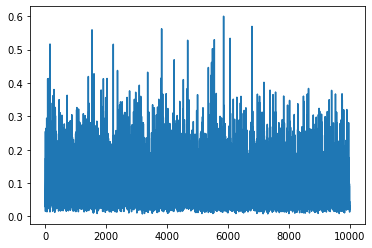

In [0]:
train(classifier=s,
      data=background,
      criterion_type=nn.BCELoss,
      optimizer_type=optim.Adam,
      ITERATIONS=20_000,
      BATCH_SIZE=32,
      LEARNING_RATE=0.001,
      VERBOSE=True,
     )


Testing 1 way accuracy ...
Completed - 100.0% accuracy

Testing 4 way accuracy ...
Completed - 93.8% accuracy

Testing 9 way accuracy ...
Completed - 89.2% accuracy

Testing 16 way accuracy ...
Completed - 81.6% accuracy

Testing 25 way accuracy ...
Completed - 74.8% accuracy

Testing 36 way accuracy ...
Completed - 65.8% accuracy

Testing 49 way accuracy ...
Completed - 66.60000000000001% accuracy

Testing 64 way accuracy ...
Completed - 56.599999999999994% accuracy

Testing 81 way accuracy ...
Completed - 55.800000000000004% accuracy

Testing 100 way accuracy ...
Completed - 52.6% accuracy
Complete!



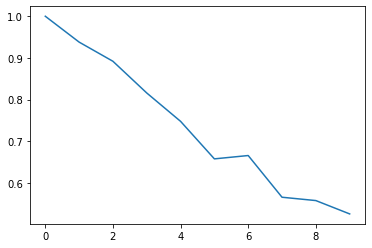

In [0]:
accuracies = []
for i in range(1, 11):
    print(f"\nTesting {i*i} way accuracy ...")
    acc = test_n_way_accuracy(classifier=s, data=evaluation, ITERATIONS=500, N=i*i)
    print(f"Completed - {acc*100}% accuracy")
    accuracies.append(acc)

print(f"Complete!\n")

plt.plot(accuracies)